**Link DRIVE với COLAB**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/BACH/archive.zip"
extract_path = "/content/BACH_raw"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Giải nén xong trong /content/BACH_raw")
!ls -la /content/BACH_raw | head

Giải nén xong trong /content/BACH_raw
total 12
drwxr-xr-x 3 root root 4096 Dec 15 22:02 .
drwxr-xr-x 1 root root 4096 Dec 15 22:02 ..
drwxr-xr-x 4 root root 4096 Dec 15 22:02 main_folder


**Cài thư viện cần thiết (chỉ chạy 1 lần / notebook mới)**

In [ ]:
!pip install -q scikit-image scikit-learn opencv-python tqdm split-folders albumentations
!pip install -q torch torchvision


In [ ]:
import os
import cv2
import gc
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.tensorboard import SummaryWriter
import shutil
from sklearn.decomposition import PCA
from skimage import io, transform

In [ ]:
class config:
    patch_size = 512
    overlap = 0.5
    batch_size = 16 # 4-> 8
    num_epochs = 25
    learning_rate = 3e-5
    num_classes = 4
    use_macenko = True
    early_normal_ratio = 0.12   # nếu ratio patches informative < 12%, gán Normal
    unsup_mean_thresh = 0.9
    unsup_var_thresh = 0.005
    unsup_edge_thresh = 0.02
    mean = np.array([0.84263392, 0.6172471, 0.71754202])
    std = np.array([0.11667027, 0.18648461, 0.16371168])
    dropout_rate = 0.3 # Added for regularization
    num_workers = 2 # Added for faster data loading

### **DATA PREPROCESSING**

In [ ]:
# Remove old intermediate patch directory if it exists
shutil.rmtree("/content/BACH_processed_patches", ignore_errors=True)

# Define paths for training and validation data
TRAIN_VAL_RAW_PATH = "/content/BACH_raw/main_folder/train_folder"

# Define paths for test data
TEST_RAW_PATH = "/content/BACH_raw/main_folder/testing_folder"

out_dir = "/content/drive/MyDrive/model"
os.makedirs(out_dir, exist_ok=True)


In [ ]:
data_dir = TRAIN_VAL_RAW_PATH

image_paths, labels = [], []
class_names = sorted(os.listdir(data_dir))

# Define common image extensions to filter files
IMAGE_EXTENSIONS = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')

for label, cls in enumerate(class_names):
    cls_dir = os.path.join(data_dir, cls)
    for f in os.listdir(cls_dir):
        # Filter out non-image files like .ipynb_checkpoints
        if not f.lower().endswith(IMAGE_EXTENSIONS):
            # print(f"Skipping non-image file/directory: {os.path.join(cls_dir, f)}") # Optionally print what's skipped
            continue
        image_paths.append(os.path.join(cls_dir, f))
        labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80-20 split)
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train images: {len(train_image_paths)}")
print(f"Validation images: {len(val_image_paths)}")


Train images: 320
Validation images: 80


### Patch tiling

In [ ]:
def tile_image(img, patch_size=512, overlap=0.5):
    stride = int(patch_size * (1 - overlap))
    patches = []
    h, w, _ = img.shape
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
    return patches

### Macenko Stain Normalization


In [ ]:
def rgb2od(I):
    I = np.asarray(I, dtype=np.float32)
    I = np.maximum(I, 1) / 255.0
    OD = -np.log(I)
    return OD

def od2rgb(OD):
    OD = np.clip(OD, 0, 5)
    I = 255 * np.exp(-OD)
    return np.clip(I, 0, 255).astype(np.uint8)

def macenko_normalize(img, alpha=1.0, beta=0.15):
    OD = rgb2od(img).reshape((-1, 3))

    # Remove background
    OD_hat = OD[(OD > beta).any(axis=1)]
    if OD_hat.shape[0] < 10:
        return img

    # PCA
    pca = PCA(n_components=2)
    pca.fit(OD_hat)
    V = pca.components_

    # Project
    C = np.dot(OD, V.T)

    # non-negative concentration
    C = np.maximum(C, 0)

    # Normalize concentration
    max_C = np.percentile(C, 99, axis=0)
    C_normalized = C / (max_C + 1e-8)

    # Reconstruct
    OD_norm = np.dot(C_normalized, V)
    OD_norm = np.maximum(OD_norm, 0)
    OD_norm = OD_norm.reshape(img.shape)

    return od2rgb(OD_norm)

In [ ]:
def get_transforms(mean, std):
    train_tf = T.Compose([
        ToPILImage(),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(20),
        T.ColorJitter(0.2,0.2,0.2),
        T.ToTensor(),
        T.Normalize(mean, std)
    ])

    val_tf = T.Compose([
        ToPILImage(),
        T.ToTensor(),
        T.Normalize(mean, std)
    ])
    return train_tf, val_tf

In [ ]:
def split_patches_advanced(patches, mean_thresh=0.9, var_thresh=0.005, edge_thresh=0.02):
    informative, non_informative = [], []
    for p in patches:
        p_norm = p / 255.0
        mean_intensity = p_norm.mean()
        var_intensity = p_norm.var()
        edges = cv2.Canny((p_norm*255).astype(np.uint8), 50,150)
        edge_ratio = edges.sum() / (p.shape[0]*p.shape[1]*255)
        if (mean_intensity < mean_thresh) and (var_intensity > var_thresh) and (edge_ratio > edge_thresh):
            informative.append(p)
        else:
            non_informative.append(p)
    return informative, non_informative

In [ ]:
def early_normal_check(img_path):
    img = np.array(Image.open(img_path).convert("RGB"))
    if config.use_macenko:
        img = macenko_normalize(img)
    patches = tile_image(img, config.patch_size, config.overlap)
    informative, _ = split_patches_advanced(
        patches, config.unsup_mean_thresh, config.unsup_var_thresh, config.unsup_edge_thresh
    )
    ratio = len(informative)/len(patches)
    is_early_normal = ratio < config.early_normal_ratio
    return is_early_normal, ratio

In [ ]:
def show_patch_bag(img_path, n_cols=6):
    img = np.array(Image.open(img_path).convert("RGB"))
    if config.use_macenko:
        img = macenko_normalize(img)
    patches = tile_image(img, config.patch_size, config.overlap)
    informative, non_informative = split_patches_advanced(
        patches, config.unsup_mean_thresh, config.unsup_var_thresh, config.unsup_edge_thresh
    )
    print(f"Total patches: {len(patches)}, Informative: {len(informative)}")
    display_patches = informative[:n_cols*n_cols]
    n_display = len(display_patches)
    n_rows = (n_display + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    axes = axes.flatten()
    for i in range(n_display):
        axes[i].imshow(display_patches[i])
        axes[i].axis("off")
    for i in range(n_display, len(axes)):
        axes[i].axis("off")
    plt.show()

### Dataset cho train/val datasets

In [ ]:
class PatchDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.data = []
        self.targets = []
        for img_path, label in zip(image_paths, labels):
            is_normal, ratio = early_normal_check(img_path)
            # Nếu early normal → gán Normal luôn, bỏ patch-level training
            if is_normal:
                self.data.append(None)
                self.targets.append(0)
            else:
                img = np.array(Image.open(img_path).convert("RGB"))
                if config.use_macenko:
                    img = macenko_normalize(img)
                patches = tile_image(img, config.patch_size, config.overlap)
                informative, _ = split_patches_advanced(
                    patches, config.unsup_mean_thresh, config.unsup_var_thresh, config.unsup_edge_thresh
                )
                for p in informative:
                    self.data.append(p)
                    self.targets.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        patch = self.data[idx]
        label = self.targets[idx]
        if patch is None:  # early normal
            return torch.zeros(3, config.patch_size, config.patch_size), torch.tensor(label)
        if self.transform:
            patch = self.transform(patch)
        return patch, torch.tensor(label)

### Data Loader

In [ ]:
train_tf, val_tf = get_transforms(config.mean, config.std)

train_dataset = PatchDataset(
    train_image_paths, train_labels,
    transform=train_tf,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers # Added num_workers
)


In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Modify the classifier to include dropout and the new number of classes
# The EfficientNet_B0_Weights.IMAGENET1K_V1 already includes a Dropout layer at index 0
# We will replace both the dropout and the linear layer to ensure correct configuration.
model.classifier = nn.Sequential(
    nn.Dropout(p=config.dropout_rate), # Apply dropout with configurable rate
    nn.Linear(model.classifier[1].in_features, config.num_classes)
)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 158MB/s]


In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*imgs.size(0)
        _, preds = torch.max(outputs,1)
        correct += (preds==labels).sum().item()
        total += imgs.size(0)
    return running_loss/total, correct/total

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss, correct, total = 0,0,0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()*imgs.size(0)
            _, preds = torch.max(outputs,1)
            correct += (preds==labels).sum().item()
            total += imgs.size(0)
    return running_loss/total, correct/total

In [ ]:
def predict_image_label(model, img_path):
    img = np.array(Image.open(img_path).convert("RGB"))
    if config.use_macenko:
        img = macenko_normalize(img)
    patches = tile_image(img, config.patch_size, config.overlap)
    informative, _ = split_patches_advanced(
        patches, config.unsup_mean_thresh, config.unsup_var_thresh, config.unsup_edge_thresh
    )
    if len(informative)/len(patches) < config.early_normal_ratio:
        return 0  # early normal

    model.eval()
    evidence_sum = torch.zeros(config.num_classes)
    with torch.no_grad():
        for p in informative:
            p_tensor = val_tf(p).unsqueeze(0).to(device) # Changed to val_tf
            logits = model(p_tensor)
            e = torch.exp(logits.squeeze())
            evidence_sum += e.cpu()
    return torch.argmax(evidence_sum).item()

In [ ]:
import torch.optim as optim

# ==============================
# Model, optimizer, criterion
# ==============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# ==============================
# Training loop
# ==============================
best_val_acc = 0
best_model_path = os.path.join(out_dir, "best_patch_model.pth")

for epoch in range(config.num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)

    # Evaluate image-level on val set
    correct_img, total_img = 0, 0
    for img_path, true_label in zip(val_image_paths, val_labels):
        pred_label = predict_image_label(model, img_path)
        if pred_label == true_label:
            correct_img +=1
        total_img +=1
    val_acc = correct_img / total_img

    print(f"Epoch {epoch+1}/{config.num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Accuracy: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"-> Best model saved with Val Accuracy: {best_val_acc:.4f}")

print(f"Training complete. Best val accuracy: {best_val_acc:.4f}, model saved at {best_model_path}")

Epoch 1/25 | Train Loss: 0.4854 | Train Acc: 0.8176 | Val Accuracy: 0.8250
-> Best model saved with Val Accuracy: 0.8250
Epoch 2/25 | Train Loss: 0.3365 | Train Acc: 0.8750 | Val Accuracy: 0.8375
-> Best model saved with Val Accuracy: 0.8375
Epoch 3/25 | Train Loss: 0.2557 | Train Acc: 0.9078 | Val Accuracy: 0.8125
Epoch 4/25 | Train Loss: 0.2002 | Train Acc: 0.9291 | Val Accuracy: 0.8125
Epoch 5/25 | Train Loss: 0.1673 | Train Acc: 0.9415 | Val Accuracy: 0.8125
Epoch 6/25 | Train Loss: 0.1454 | Train Acc: 0.9514 | Val Accuracy: 0.8625
-> Best model saved with Val Accuracy: 0.8625
Epoch 7/25 | Train Loss: 0.1287 | Train Acc: 0.9551 | Val Accuracy: 0.8250
Epoch 8/25 | Train Loss: 0.1125 | Train Acc: 0.9623 | Val Accuracy: 0.8375
Epoch 9/25 | Train Loss: 0.0976 | Train Acc: 0.9675 | Val Accuracy: 0.8250
Epoch 10/25 | Train Loss: 0.0882 | Train Acc: 0.9723 | Val Accuracy: 0.8500
Epoch 11/25 | Train Loss: 0.0774 | Train Acc: 0.9752 | Val Accuracy: 0.8500
Epoch 12/25 | Train Loss: 0.0760 | 

### Load best model

In [ ]:
best_model_path = "/content/drive/MyDrive/model/best_patch_model.pth"
model.load_state_dict(torch.load(best_model_path))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### TEST + EVALUATION

In [ ]:
test_image_paths = []
test_labels = []

class_names = sorted(os.listdir(TEST_RAW_PATH))
for label, cls in enumerate(class_names):
    cls_dir = os.path.join(TEST_RAW_PATH, cls)
    for f in os.listdir(cls_dir):
        if f.lower().endswith(IMAGE_EXTENSIONS):
            test_image_paths.append(os.path.join(cls_dir, f))
            test_labels.append(label)

test_dataset = PatchDataset(
    test_image_paths, test_labels,
    transform=val_tf,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers
)

### Test accuracy + confusion matrix

100%|██████████| 77/77 [00:13<00:00,  5.62it/s]

Test Accuracy: 0.9357723577235773


<Figure size 640x480 with 0 Axes>

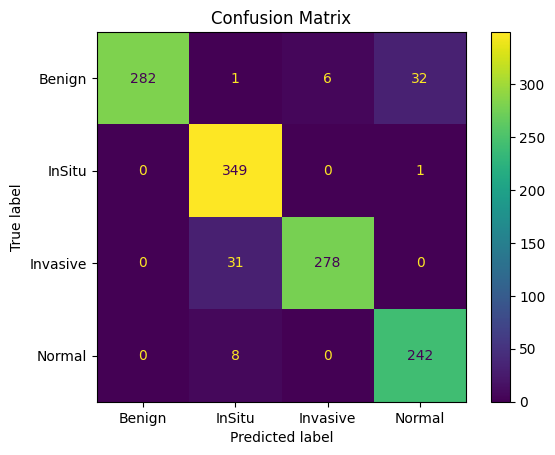

              precision    recall  f1-score   support

      Benign       1.00      0.88      0.94       321
      InSitu       0.90      1.00      0.94       350
    Invasive       0.98      0.90      0.94       309
      Normal       0.88      0.97      0.92       250

    accuracy                           0.94      1230
   macro avg       0.94      0.94      0.93      1230
weighted avg       0.94      0.94      0.94      1230



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm import tqdm
import torch

@torch.no_grad()
def test_model_patch(model, loader):
    model.eval()
    y_true, y_pred = [], []

    for patches, labels in tqdm(loader):
        patches, labels = patches.to(device), labels.to(device)
        logits = model(patches) # Model outputs only logits
        preds = logits.argmax(dim=1) # Get predictions for the entire batch

        y_true.extend(labels.cpu().numpy()) # Extend with true labels from batch
        y_pred.extend(preds.cpu().numpy())  # Extend with predicted labels from batch

    return np.array(y_true), np.array(y_pred)

def test_model_image(model,  image_paths, true_labels):
    model.eval()
    y_true, y_pred = [], []

    for img_path, true_label in tqdm(zip(image_paths, true_labels), total=len(image_paths)):
        pred_label = predict_image_label(model, img_path)
        y_true.append(true_label)
        y_pred.append(pred_label)

    return np.array(y_true), np.array(y_pred)

# ===== RUN TEST =====
y_true_patch, y_pred_patch = test_model_patch(model, test_loader)
y_true_image, y_pred_image = test_model_image(model, test_image_paths, test_labels)

# ===== Accuracy =====
print("Test Accuracy:", (y_true_patch == y_pred_patch).mean())
print("Test Accuracy:", (y_true_image == y_pred_image).mean())

# ===== Confusion Matrix =====
cm = confusion_matrix(y_true_patch, y_pred_patch)

plt.figure()
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot()
plt.title("Confusion Matrix Patch Level")
plt.show()

cm1 = confusion_matrix(y_true_image, y_pred_image)

plt.figure()
disp1 = ConfusionMatrixDisplay(
    confusion_matrix=cm1,
    display_labels=class_names
)
disp1.plot()
plt.title("Confusion Matrix Image Level")
plt.show()
# ===== Classification Report =====
print(classification_report(y_true_patch, y_pred_patch, target_names=class_names))
